In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import tensorflow as tf
import json
from sklearn.preprocessing import LabelEncoder

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.254.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.254.58:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [4]:
%cd gdrive/MyDrive/CSE4095\ -\ NLP/Delivery-3/

/content/gdrive/MyDrive/CSE4095 - NLP/Delivery-3


Read the processed (i.e., tokenized) dataset, labels, and splitted data (similar to Delivery 2)

In [5]:
dataset = {}
with open('data/dataset.json', encoding='utf-8') as fr:
    dataset = json.load(fr)

In [6]:
labels = {}
with open('data/labels.json', encoding='utf-8') as fr:
    labels = json.load(fr)

In [7]:
splitted_data = {}
with open('data/splitted_data.json', encoding='utf-8') as fr:
    splitted_data = json.load(fr)

Transform labels to integers

In [8]:
def encode_labels(labels):
    le = LabelEncoder()
    y = le.fit_transform(labels)
    return y

In [9]:
X_train, X_test, y_train, y_test = [], [], [], []

for key in ['train', 'test']:
    for i in range(len(splitted_data[f'X_{key}'])):
        exec(f"X_{key}.append(dataset[splitted_data['X_{key}'][i]])")
        exec(f"y_{key}.append(splitted_data['y_{key}'][i])")

In [10]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)

Create iterable Keras Dataset

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Print a sample instance along its label from the training dataset

In [12]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy().decode('utf-8'))
    print()
    print('labels: ', label.numpy())

texts:  hüküm çocuğun cinsel istismarı ve tehdit suçlarından beraat hakaret suçundan mahkumiyet i̇lk derece mahkemesince verilen hükümler temyiz edilmekle başvurunun muhtevası ve inceleme tarihine kadar getirilen kanuni düzenlemeler nazara alınarak dosya tetkik edildi gereği görüşüldü muhakeme safahatını yansıtan tutanaklar belgeler ve gerekçe içeriğine göre yapılan incelemede iddia ve savunma ile tüm delillerin eksiksiz olarak kararda gösterildiği hükmedilen ceza nevi ve miktarı itibarıyla kanuni sınırlar içinde tayin edildiği gibi beraat hükümlerinin de dosya kapsamına uygun olduğu anlaşıldığından sanık müdafisi ve katılan mağdur vekili ile yer cumhuriyet savcısının yerinde görülmeyen temyiz taleplerinin reddiyle hükümlerin onanmasina tarihinde oy birliğiyle karar verildi

labels:  2


Preprocess the datasets

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 512
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create an encoder layer for text vectorization

In [14]:
VOCAB_SIZE = 60724
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Create the model, compile, train and evaluate

In [15]:
type_ = 'lstm'
if type_ == 'lstm':
    lstm_layer = tf.keras.layers.LSTM(256)
else:
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        mask_zero=True),
    lstm_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [16]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,
                                                             decay_steps=10000,
                                                             decay_rate=0.9)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset)

Epoch 1/20
44/44 [==============================] - 896s 20s/step - loss: 1.5791 - accuracy: 0.5017 - val_loss: 1.1985 - val_accuracy: 0.5672
Epoch 2/20
44/44 [==============================] - 907s 20s/step - loss: 1.0149 - accuracy: 0.6624 - val_loss: 0.8160 - val_accuracy: 0.7396
Epoch 3/20
44/44 [==============================] - 881s 20s/step - loss: 0.7212 - accuracy: 0.7620 - val_loss: 0.6291 - val_accuracy: 0.8009
Epoch 4/20
44/44 [==============================] - 890s 20s/step - loss: 0.5289 - accuracy: 0.8306 - val_loss: 0.4917 - val_accuracy: 0.8467
Epoch 5/20
44/44 [==============================] - 912s 21s/step - loss: 0.4462 - accuracy: 0.8568 - val_loss: 0.4734 - val_accuracy: 0.8495
Epoch 6/20
44/44 [==============================] - 925s 21s/step - loss: 0.3800 - accuracy: 0.8756 - val_loss: 0.4488 - val_accuracy: 0.8614
Epoch 7/20
44/44 [==============================] - 868s 20s/step - loss: 0.3384 - accuracy: 0.8891 - val_loss: 0.4282 - val_accuracy: 0.8678
Epoch 

In [18]:
classes = ['Aldatmaya-Yönelik-Suç', 'Cana-Kastetme-Suçu', 'Cinsel-Saldırı-Suçu',
           'Hakaret', 'Kanuna/Yasaya-Muhalefet-Olma', 'Other', 'Tehdit', 'Trafik-Suçu',
           'Uyuşturucu-Madde-Suçu', 'Yaralama', 'undefined', 'İzinsiz-Mal-Alma-Suçu']

In [20]:
preds = model.predict(test_dataset)

In [26]:
y_pred = []
for arr in preds:
    y_pred.append(np.argmax(arr))

len(y_pred)

5569

In [27]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [28]:
cr = classification_report(y_test, y_pred, target_names=classes)
print(cr)

                              precision    recall  f1-score   support

       Aldatmaya-Yönelik-Suç       0.72      0.87      0.79       237
          Cana-Kastetme-Suçu       0.81      0.67      0.74        64
         Cinsel-Saldırı-Suçu       0.98      0.89      0.93       148
                     Hakaret       0.43      0.58      0.50       118
Kanuna/Yasaya-Muhalefet-Olma       0.85      0.84      0.85       352
                       Other       0.64      0.74      0.69       493
                      Tehdit       0.69      0.61      0.64       359
                 Trafik-Suçu       0.90      0.85      0.88        41
       Uyuşturucu-Madde-Suçu       0.95      0.94      0.94       232
                    Yaralama       0.88      0.80      0.84       546
                   undefined       0.98      0.97      0.98      2589
       İzinsiz-Mal-Alma-Suçu       0.87      0.86      0.86       390

                    accuracy                           0.87      5569
                  

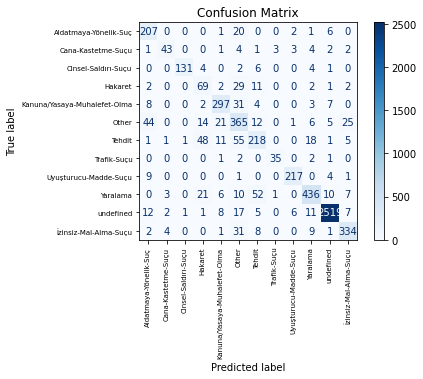

In [29]:
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title('Confusion Matrix')

plt.xticks(rotation = 90, fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('results/lstm_cm.png', dpi=300, bbox_inches='tight')